# E-commerce purchase prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('ecommerce_behavior.csv')

df['view_to_cart_ratio'] = df['cart_adds'] / (df['views'] + 1)
df['price_discounted'] = df['price'] * (1 - df['discount'])
df['expensive'] = (df['price'] > 500).astype(str)
df['is_mobile'] = (df['device'] == 'Mobile').astype(str)

In [3]:
df.describe()

,price,discount,views,cart_adds,rating,purchased,view_to_cart_ratio,price_discounted
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,493.200916,0.251898,2.991200,0.911000,3.748300,0.319800,0.206754,369.442563
std,287.392505,0.144912,1.731162,0.959616,0.715083,0.466446,0.203874,231.930928
min,5.010000,0.000000,0.000000,0.000000,2.500000,0.000000,0.000000,2.754000
25%,239.292500,0.130000,2.000000,0.000000,3.100000,0.000000,0.000000,173.981425
50%,490.775000,0.250000,3.000000,1.000000,3.700000,0.000000,0.200000,350.687600
75%,739.932500,0.380000,4.000000,1.000000,4.400000,1.000000,0.333333,531.272750
max,999.520000,0.500000,11.000000,7.000000,5.000000,1.000000,0.857143,978.314400


In [4]:
# Here we see that dataset is imbalanced
df['purchased'].value_counts(normalize=True)

purchased
0    0.6802
1    0.3198
Name: proportion, dtype: float64

In [5]:
X = df.drop('purchased', axis=1)
y = df['purchased']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [6]:
num_features = X.select_dtypes(include=['int64','float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

num_transformer_poly = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Creating preprocessor for Logistic Regression with PolymonailFeatures
preprocessor_with_poly = ColumnTransformer(transformers=[
    ('num', num_transformer_poly, num_features),
    ('cat', cat_transformer, cat_features)
])


num_transformer_plain = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Creating preprocessor for other models without PolymonailFeatures
preprocessor_no_poly = ColumnTransformer(transformers=[
    ('num', num_transformer_plain, num_features),
    ('cat', cat_transformer, cat_features)
])


In [7]:
best_model = []

In [8]:
# Searching for the best parameters for Log Regression
param_grid_log_reg = {
    'classifier__C': [0.01, 0.1, 0.3, 0.5, 0.8, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

pipe_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor_with_poly),
    ('classifier', LogisticRegression(solver='liblinear'))
])

grid_search_logreg = GridSearchCV(
    pipe_logreg,
    param_grid_log_reg,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

grid_search_logreg.fit(X_train, y_train)

# Creating Log Regression with best params
best_logreg_model = grid_search_logreg.best_estimator_

y_pred_log = best_logreg_model.predict(X_test)
y_proba_log = best_logreg_model.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred_log)
roc_auc = roc_auc_score(y_test, y_proba_log)

best_model.append({
    'model': 'Logistic Regression',
    'f1_score': round(f1, 3),
    'roc_auc':round(roc_auc, 3)
}
)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [9]:
# Searching for the best parameters for Random Forest
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 3]
}

pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_no_poly),
    ('classifier', RandomForestClassifier(random_state=42))
])

grid_search_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

# Creating Random Forest with best params
best_rf_model = grid_search_rf.best_estimator_

y_pred_rf = best_rf_model.predict(X_test)
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, y_proba_rf)

best_model.append({
    'model': 'Random Forest',
    'f1_score': round(f1, 3),
    'roc_auc':round(roc_auc, 3)
}
)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [10]:
# Searching for the best parameters for XGBoost
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0]
}

pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor_no_poly),
    ('classifier', XGBClassifier(eval_metric='logloss'))
])

grid_search_xgb = GridSearchCV(
    pipe_xgb,
    param_grid_xgb,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)

# Creating Random Forest with best params
best_xgb_model = grid_search_xgb.best_estimator_

y_pred_xgb = best_xgb_model.predict(X_test)
y_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred_xgb)
roc_auc = roc_auc_score(y_test, y_proba_xgb)

best_model.append({
    'model': 'XGB',
    'f1_score': round(f1, 3),
    'roc_auc':round(roc_auc, 3)
}
)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [11]:
# Comparing the results of models
result = pd.DataFrame(best_model)
result

,model,f1_score,roc_auc
0,Logistic Regression,0.320,0.707
1,Random Forest,0.151,0.712
2,XGB,0.201,0.723


**Logistic Regression shows the best result based on the evaluation. ROC AUC 0.7 means that the model distinguishes well between users who make purchases and** 
**those who do not.**
**Considering that the data is unbalanced, F1 shows an acceptable result. The model correctly guesses 1 out of 3.**

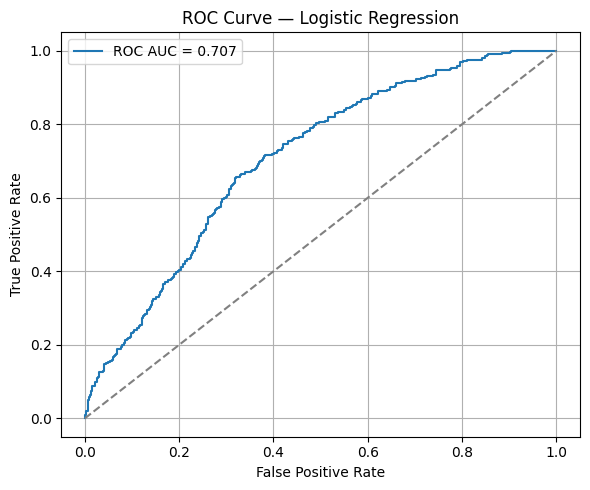

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_log)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba_log):.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

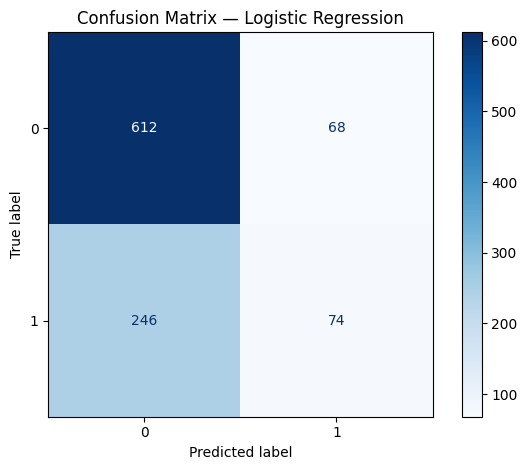

In [37]:
conf_matrix = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Logistic Regression")
plt.grid(False)
plt.tight_layout()
plt.show()